In [9]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


In [10]:
import math


def cie76(c1, c2):
	"""
	Color comparision using CIE76 algorithm.
	Returns a value between 0 and 100.
	Where 0 is a perfect match and 100 is opposing colors.
	http://zschuessler.github.io/DeltaE/learn/
	LAB Delta E - version CIE76
	https://en.wikipedia.org/wiki/Color_difference
	E* = 2.3 corresponds to a JND (just noticeable difference)
	"""
	return math.sqrt(
		math.pow(c2[0] - c1[0], 2) +
		math.pow(c2[1] - c1[1], 2) +
		math.pow(c2[2] - c1[2], 2)
	)


def rgb_xyz(rgb):
	"""
	Convert tuple from the sRGB color space to the CIE XYZ color space.
	The XYZ output is determined using D65 illuminate with a 2° observer angle.
	https://en.wikipedia.org/wiki/Illuminant_D65
	sRGB (standard Red Green Blue): https://en.wikipedia.org/wiki/SRGB
	CIE XYZ: https://en.wikipedia.org/wiki/CIE_1931_color_space
	"""
	r = __pivot_rgb_xyz(rgb[0] / 255.0)
	g = __pivot_rgb_xyz(rgb[1] / 255.0)
	b = __pivot_rgb_xyz(rgb[2] / 255.0)

	x = r * 0.4124 + g * 0.3576 + b * 0.1805
	y = r * 0.2126 + g * 0.7152 + b * 0.0722
	z = r * 0.0193 + g * 0.1192 + b * 0.9505

	return x, y, z


def __pivot_rgb_xyz(value):
	if value > 0.04045:
		value = math.pow((value + 0.055) / 1.055, 2.4)
	else:
		value /= 12.92
	return value * 100.0


def xyz_rgb(xyz):
	"""
	Convert tuple from the CIE XYZ color space to the sRGB color space.
	Conversion is based on that the XYZ input uses an the D65 illuminate with a 2° observer angle.
	https://en.wikipedia.org/wiki/Illuminant_D65
	sRGB (standard Red Green Blue): https://en.wikipedia.org/wiki/SRGB
	CIE XYZ: https://en.wikipedia.org/wiki/CIE_1931_color_space
	"""
	x = xyz[0] / 100.0
	y = xyz[1] / 100.0
	z = xyz[2] / 100.0

	r = x * 3.2406 + y * -1.5372 + z * -0.4986
	g = x * -0.9689 + y * 1.8758 + z * 0.0415
	b = x * 0.0557 + y * -0.2040 + z * 1.0570

	r = __pivot_xyz_rgb(r) * 255.0
	g = __pivot_xyz_rgb(g) * 255.0
	b = __pivot_xyz_rgb(b) * 255.0

	return round(r), round(g), round(b)


def __pivot_xyz_rgb(value):
	if value > 0.0031308:
		value = 1.055 * math.pow(value, (1.0 / 2.4)) - 0.055
	else:
		value = 12.92 * value
	return value


def xyz_lab(xyz):
	"""
	Convert tuple from the CIE XYZ color space to the CIE L*a*b color space.
	Conversion is based on that the XYZ input uses an the D65 illuminate with a 2° observer angle.
	https://en.wikipedia.org/wiki/Illuminant_D65
	CIE L*a*b: https://en.wikipedia.org/wiki/Lab_color_space
	CIE XYZ: https://en.wikipedia.org/wiki/CIE_1931_color_space
	"""
	x = __pivot_xyz_lab(xyz[0] / 95.047)
	y = __pivot_xyz_lab(xyz[1] / 100.000)
	z = __pivot_xyz_lab(xyz[2] / 108.883)

	l = max(0.0, (116.0 * y) - 16.0)
	a = 500.0 * (x - y)
	b = 200.0 * (y - z)

	return l, a, b


def __pivot_xyz_lab(value):
	if value > 0.008856:
		value = math.pow(value, 1.0 / 3.0)
	else:
		value = (value * 7.787) + (16.0 / 116.0)
	return value


def lab_xyz(lab):
	"""
	Convert tuple from the CIE L*a*b* color space to the CIE XYZ color space.
	The XYZ output is determined using D65 illuminate with a 2° observer angle.
	https://en.wikipedia.org/wiki/Illuminant_D65
	CIE L*a*b: https://en.wikipedia.org/wiki/Lab_color_space
	CIE XYZ: https://en.wikipedia.org/wiki/CIE_1931_color_space
	"""
	y = (lab[0] + 16.0) / 116.0
	x = lab[1] / 500.0 + y
	z = y - lab[2] / 200.0

	x = __pivot_lab_xyz(x) * 95.047
	y = __pivot_lab_xyz(y) * 100.000
	z = __pivot_lab_xyz(z) * 108.883

	return x, y, z


def __pivot_lab_xyz(value):
	if value > 0.008856:
		value = math.pow(value, 3)
	else:
		value = (value - 16.0 / 116.0) / 7.787
	return value


def rgb_lab(rgb):
	"""
	Convert tuple from the sRGB color space to the CIE L*a*b* color space.
	Shorthand method for chaining sRGB => CIE XYZ => CIE L*a*b*.
	"""
	return xyz_lab(rgb_xyz(rgb))


def lab_rgb(lab):
	"""
	Convert tuple from the CIE L*a*b* color space to the sRGB color space.
	Shorthand method for chaining CIE L*a*b* => CIE XYZ  => sRGB.
	"""
	return xyz_rgb(lab_xyz(lab))

In [11]:
import argparse
import math
import os
import time
from collections import defaultdict
from PIL import Image, ImageDraw


DEFAULT_TOLERANCE = 32


def extract(path, tolerance=DEFAULT_TOLERANCE, limit=None):
	pixels = load(path)
	counter = count_colors(pixels)
	tmp = dict()
	for color, count in counter.items():
		tmp[rgb_lab(color)] = count

	counter = compress(tmp, tolerance)
	counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)

	if limit:
		counter = counter[:min(int(limit), len(counter))]

	counter = [(to_int(lab_rgb(c[0])), c[1]) for c in counter]

	return counter, len(pixels)

def to_int(tuple):
	return int(tuple[0]), int(tuple[1]), int(tuple[2])

def load(path):
    img = Image.fromarray(path, 'RGB')
    return list(img.getdata())
def count_colors(pixels):
	counter = defaultdict(int)
	for color in pixels:
		counter[color] += 1
	return counter


def compress(counter, tolerance):
	result = counter
	if tolerance <= 0:
		return result

	colors = [item[0] for item in sorted(counter.items(), key=lambda x: x[1], reverse=True)]
	i = 0
	while i < len(colors):
		larger = colors[i]

		j = i + 1
		while j < len(colors):
			smaller = colors[j]
			if cie76(smaller, larger) < tolerance:
				result[larger] += result[smaller]
				result.pop(smaller)
				colors.remove(smaller)
			else:
				j += 1
		i += 1

	return result


def print_result(counter, total):
	print("Extracted colors:")
	for key, value in counter:
		print("{0:15}:{1:>7}% ({2})".format(str(key), "{0:.2f}".format((float(value) / float(total)) * 100.0), value))
	print("\nPixels in output: {} of {}".format(sum([c[1] for c in counter]), total))


def image_result(counter, size, filename):
	columns = 5
	width = int(min(len(counter), columns) * size)
	height = int((math.floor(len(counter) / columns) + 1) * size)

	result = Image.new("RGBA", (width, height), (0, 0, 0, 0))
	canvas = ImageDraw.Draw(result)
	for idx, item in enumerate(counter):
		x = int((idx % columns) * size)
		y = int(math.floor(idx / columns) * size)
		canvas.rectangle([(x, y), (x + size - 1, y + size - 1)], fill=item[0])

	filename = "{0} {1}.png".format(filename, time.strftime("%Y-%m-%d %H%M%S", time.localtime()))
	result.save(filename, "PNG")


def parse_tolerance(value):
	value = float(value)
	if value < 0 or value > 100:
		raise argparse.ArgumentTypeError("{} isn't a integer between 0 and 100".format(value))
	return value


def parse_limit(value):
	value = int(value)
	if value < 0:
		raise argparse.ArgumentTypeError("{} isn't a positive integer".format(value))
	return value

In [12]:
file_path = 'the_great_wall/the_great_wall.mkv'
# file_path = 'the_golden_flower/the_golden_flower.mp4'
# file_path = 'hero/hero.mp4'
# file_path = 'shadow/shadow.mp4'
# file_path = 'lovers/lovers.mp4'
cap = cv2.VideoCapture(file_path)
file_name = 'the_great_wall'


In [13]:
# lovers 3,24
# hero 0, 27
# the golden flower 2,25
# the great wall 3,24
# shadow 3,24
width = 64
height= 27

start_clip = 3
end_cilp = 24
# for _ in range(100):
#     ret,img_orig = cap.read()
# img_new = cv2.resize(img_orig, (width, height))
# img_new = cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB)
# plt.imshow(img_new[start_clip:end_cilp,:,:])

# plt.show()

# extract color each second

In [14]:
# frame_nums = 10000
width = 64
height= 27
# the golden flower(2,25) hero(0,27) lovers(3,24) the great wall(3,24)
height_remain = end_cilp-start_clip
frame_nums = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_image = np.zeros((int((height_remain)*width),int(frame_nums/24)+1,3))
f = open(file_name+"/"+file_name+"_color.txt","w") 

for i in range(frame_nums):
    ret,img_orig = cap.read()
    
    if not ret:
        break
    if (i+1)%24 == 0:
        current_start_sec = int(np.floor(i/24)) 
        f.write(str(int((i+1)/24))+' ')
        img_orig = img_orig
        img_new = cv2.resize(img_orig, (width, height))
        img_new = cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB)
        # for Lovers only
        img_new = img_new[start_clip:end_cilp,:,:]
        cv2.imwrite(file_name+"/images/"+file_name+"_" + str(current_start_sec) + ".jpg", cv2.cvtColor(img_new, cv2.COLOR_RGB2BGR))
        
        colors, pixel_count = extract(img_new)
        
        new_color_sum = []
        for color_ind,color in enumerate(colors):
            new_color_sum.append(np.sum(color[0]))
        new_color_ind = sorted(range(len(new_color_sum)), key=lambda k: new_color_sum[k])
        
        # show image
        cnt = 0

        for color_ind in new_color_ind:
            for j in range(colors[color_ind][1]):
                frame_image[cnt,int((i+1)/24),:] = colors[color_ind][0]
                cnt = cnt + 1
        
        # make file
        for color_ind in new_color_ind:
            f.write(str(colors[color_ind][0][0])+',')
            f.write(str(colors[color_ind][0][1])+',')
            f.write(str(colors[color_ind][0][2])+',')
            f.write(str(colors[color_ind][1]/(float(width)*float(height_remain)))+' ')
        f.write('\n')
f.close()

In [15]:
# display colors from movie
plt.close()
plt.figure(figsize=(20,12),dpi=100)
plt.imshow(frame_image.astype(np.uint8))

plt.axis('off')
plt.tight_layout()
plt.savefig(file_name+"/"+file_name+'_color')


# calculate frequency from movie

In [6]:
cap = cv2.VideoCapture(file_path)

In [7]:
def str2sec(timestamp):
    return int(timestamp[:2]) * 3600 + int(timestamp[2:4]) * 60 + int(timestamp[4:6])

In [8]:
# read lines from text
file_dir = file_name+'/movie.csv'
with open(file_dir, 'r') as infile:
    movie_data = infile.readlines()
    
time_secs = {}
for line in movie_data:
    line = line.split(',')
    start_time = line[2]
    end_time = line[3]
    start_sec = str2sec(start_time)
    end_sec = str2sec(end_time)
    time_secs[start_sec] = end_sec
    

In [9]:
print(time_secs.keys())
print(time_secs.values())
test_diff = [end-start for start,end in zip(time_secs.keys(),time_secs.values())]
print(test_diff)
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]


dict_keys([64, 78, 129, 161, 262, 451, 564, 572, 577, 578, 580, 581, 585, 588, 593, 624, 647, 656, 751, 957, 1157, 1178, 1284, 1478, 2496, 2580, 2737, 2897, 3218, 3412, 4190, 4213, 4371, 4377, 4423, 4446, 4462, 4480, 4494, 4511, 4793, 5149, 5187, 5215, 5306, 5933, 6140, 6443, 6457, 6468])
dict_values([70, 123, 161, 220, 383, 553, 569, 577, 578, 579, 581, 582, 587, 593, 623, 643, 656, 660, 787, 1036, 1159, 1278, 1366, 2450, 2559, 2699, 2747, 3187, 3369, 4136, 4202, 4349, 4374, 4382, 4444, 4451, 4464, 4489, 4509, 4696, 5093, 5175, 5195, 5247, 5680, 6021, 6183, 6445, 6468, 6660])
[6, 45, 32, 59, 121, 102, 5, 5, 1, 1, 1, 1, 2, 5, 30, 19, 9, 4, 36, 79, 2, 100, 82, 972, 63, 119, 10, 290, 151, 724, 12, 136, 3, 5, 21, 5, 2, 9, 15, 185, 300, 26, 8, 32, 374, 88, 43, 2, 11, 192]


In [10]:
frame_nums = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
ind_frame = 0
line_diffs = []
found_key = []
while ind_frame<frame_nums:
    
    if int(np.floor(ind_frame/24)) in time_secs.keys():
        found_key.append(int(np.floor(ind_frame/24)))
        current_start_sec = int(np.floor(ind_frame/24)) 
        _,img_orig = cap.read()
        ind_frame = ind_frame+1
        
        img_old = cv2.resize(img_orig, (width, height))
        img_old = cv2.cvtColor(img_old, cv2.COLOR_BGR2RGB)
        img_old = img_old[start_clip:end_cilp,:,:]
        diffs = []
        while int(np.floor(ind_frame/24))<time_secs[current_start_sec]:
            _,img_orig = cap.read()
            img_new = cv2.resize(img_orig, (width, height))
            img_new = cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB)
            img_new = img_new[start_clip:end_cilp,:,:]
            diff = np.mean(np.abs(img_new-img_old))
            diffs.append(diff)
            img_old = img_new.copy()
            ind_frame = ind_frame+1
        line_diffs.append(diffs)      
    else:
        _,_ = cap.read()
        ind_frame = ind_frame+1

In [11]:
print(time_secs.keys())
print(time_secs.values())
test_all_key = [key for key in time_secs.keys()]
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]
for key in diff(test_all_key,found_key):
    print(test_all_key.index(key))
    print('start_time:',key)
    print('end_time:',time_secs[key])

dict_keys([64, 78, 129, 161, 262, 451, 564, 572, 577, 578, 580, 581, 585, 588, 593, 624, 647, 656, 751, 957, 1157, 1178, 1284, 1478, 2496, 2580, 2737, 2897, 3218, 3412, 4190, 4213, 4371, 4377, 4423, 4446, 4462, 4480, 4494, 4511, 4793, 5149, 5187, 5215, 5306, 5933, 6140, 6443, 6457, 6468])
dict_values([70, 123, 161, 220, 383, 553, 569, 577, 578, 579, 581, 582, 587, 593, 623, 643, 656, 660, 787, 1036, 1159, 1278, 1366, 2450, 2559, 2699, 2747, 3187, 3369, 4136, 4202, 4349, 4374, 4382, 4444, 4451, 4464, 4489, 4509, 4696, 5093, 5175, 5195, 5247, 5680, 6021, 6183, 6445, 6468, 6660])


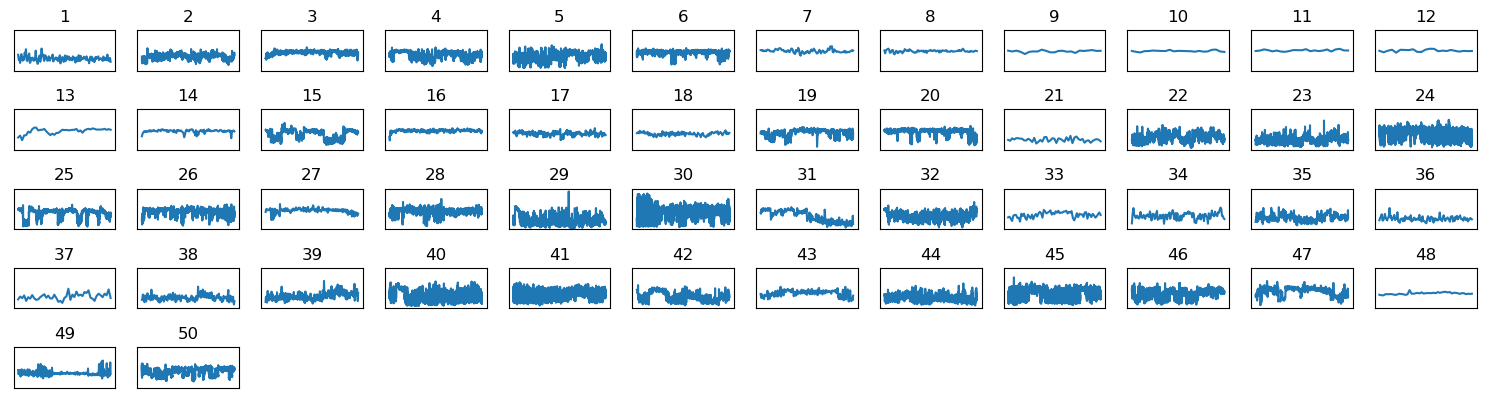

In [12]:
# plot line_diffs
# figsize width*height
plt.close()
fig_height = 12
fig_width = 15
plt.figure(figsize=(fig_width,fig_height),dpi=100)
for plt_ind in range(1,len(line_diffs)+1):
    plt.subplot(fig_width,fig_height,plt_ind)
    plt.plot(range(len(line_diffs[plt_ind-1])),line_diffs[plt_ind-1])
    plt.ylim([0,255])
    plt.title(str(plt_ind))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [13]:
# calculate histogram
line_histograms = []
bin_nums = 100
max_line_diffs = max([max(line_diff) for line_diff in line_diffs])
min_line_diffs = min([min(line_diff) for line_diff in line_diffs])
step_line_diffs = (max_line_diffs-min_line_diffs)/float(bin_nums)
for line_diff in line_diffs:
    initial_bins = [0 for _ in range(bin_nums)]
    for diff in line_diff:
        if diff == max_line_diffs:
            initial_bins[-1] = initial_bins[-1]+1
        else:
            ind_bin = int(np.floor((diff - min_line_diffs)/step_line_diffs))
            initial_bins[ind_bin] = initial_bins[ind_bin]+1
    initial_bins = [bin_val/float(len(line_diff)) for bin_val in initial_bins]
    line_histograms.append(initial_bins)


In [14]:
# calculate freq
line_histogram_maxs = []

for line_histogram in np.array(line_histograms):
    line_histogram_maxs.append(np.argmax(line_histogram))
max_val = max(line_histogram_maxs)
min_val = min(line_histogram_maxs)
level_nums = 10
step_val = (max_val-min_val)/float(level_nums)
final_level = [0 for _ in range(len(line_histogram_maxs))]
for hist_ind,hist_val in enumerate(line_histogram_maxs):
    if hist_val == max_val:
        final_level[hist_ind] = 10
    else:
        final_level[hist_ind] = int(np.floor((hist_val-min_val)/step_val))

In [15]:
# plot line_diffs
# figsize width*height
plt.close()
plt.figure(figsize=(fig_width,fig_height),dpi=100)
for plt_ind in range(1,len(line_histograms)+1):
    plt.subplot(fig_width,fig_height,plt_ind)
    plt.plot(range(bin_nums),line_histograms[plt_ind-1])
    plt.plot([line_histogram_maxs[plt_ind-1] for _ in range(bin_nums)],[0.01*bin_val for bin_val in range(bin_nums)],'r--')
    plt.ylim([0,0.3])
    plt.title(str(plt_ind))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
# plt.show()
plt.savefig(file_name+"/"+file_name+'_frequency')

In [17]:
final_level_dict ={}
for level_ind,level in enumerate(final_level):
    final_level_dict[level_ind+1] = level
print(final_level_dict)

{1: 3, 2: 6, 3: 8, 4: 8, 5: 5, 6: 8, 7: 10, 8: 9, 9: 9, 10: 9, 11: 9, 12: 9, 13: 9, 14: 9, 15: 9, 16: 8, 17: 7, 18: 7, 19: 9, 20: 9, 21: 2, 22: 2, 23: 1, 24: 9, 25: 7, 26: 8, 27: 8, 28: 8, 29: 0, 30: 9, 31: 8, 32: 2, 33: 6, 34: 3, 35: 2, 36: 1, 37: 2, 38: 2, 39: 1, 40: 2, 41: 3, 42: 1, 43: 7, 44: 1, 45: 3, 46: 8, 47: 9, 48: 5, 49: 5, 50: 8}


In [19]:
f = open(file_name+"/"+file_name+"_freq.txt","w") 
for level in final_level:
    f.write(str(level)+',\n')
f.close()